# Analyse processed wave height data

Data processed with zero-crossing and spectral analysis methods

In [88]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates  
%matplotlib inline

In [90]:
############ A1        A2       P1
colours = ['#377eb8','#ff7f00','#984ea3']

In [147]:
### Data analysed with spectral method

PT_s = pd.read_csv(r'..\Data_final\20250123_P1_wave_spectral_analysis.csv')

A1_s = pd.read_csv(r'..\Data_final\20250123_A1_wave_spectral_analysis.csv')

A2_s = pd.read_csv(r'..\Data_final\20250123_A2_wave_spectral_analysis.csv')

### Data analysed with zero-crossing method

PT_z = pd.read_csv(r'..\Data_final\20250123_P1_wave_zero_crossing_analysis.csv')

A1_z = pd.read_csv(r'..\Data_final\20250123_A1_wave_zero_crossing_analysis.csv')

A2_z = pd.read_csv(r'..\Data_final\20250123_A2_wave_zero_crossing_analysis.csv')


In [149]:
alldata = [PT_s, A1_s, A2_s, PT_z, A1_z, A2_z]

for data in alldata:
    data['time'] = pd.to_datetime(data['time'])

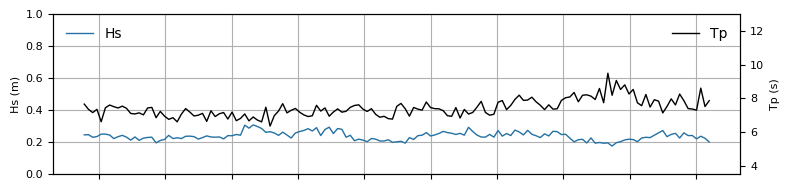

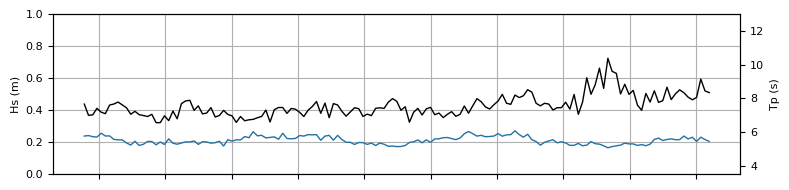

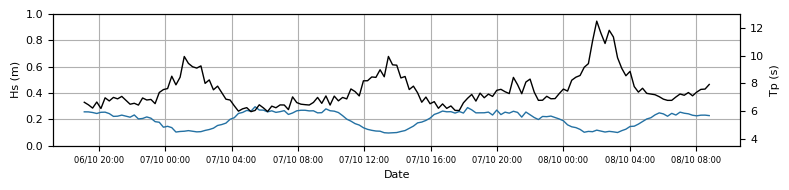

In [151]:
def plot_waves(PT_s, instrument):
    fig, (ax0) = plt.subplots(figsize=(8,2), dpi=100)

    # Plot Hs on ax0
    ax0.plot(PT_s.time, PT_s.Hs, lw=1, c='#2471A3', label='Hs')

    # Create a second y-axis for Tp on ax1
    ax1 = ax0.twinx()
    ax1.plot(PT_s.time, PT_s.Ts, lw=1, c='k', label='Tp')

    # Adjust tick parameters and font sizes
    ax0.tick_params(axis='both', which='major', labelsize=8)  # Adjust label size for ax0
    ax1.tick_params(axis='both', which='major', labelsize=8)  # Adjust label size for ax1

    # Set axis labels
    ax0.set_ylabel('Hs (m)', fontsize=8)
    ax1.set_ylabel('Tp (s)', fontsize=8)

    # Set axis limits
    ax0.set_ylim(0, 1)
    ax1.set_ylim(3.5, 13)

    # Add grid to ax0
    ax0.grid()

    # Instrument-specific behavior
    if instrument == 'A1':
        ax1.set_xticklabels([])  # Remove x-axis labels for ax1
        ax1.legend(loc=1, frameon=False)  # Legend for ax1
        ax0.legend(loc=2, frameon=False)  # Legend for ax0
    if instrument == 'A2':
        ax1.set_xticklabels([])  # Remove x-axis labels for ax1
    if instrument == 'PT':
        ax0.set_xlabel('Date', fontsize=8)
        ax0.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))

        # Make x-axis label font smaller using plt.setp
        plt.setp(ax0.get_xticklabels(), fontsize=6)  # Set font size for x-axis labels

    # Save the plot
    plt.tight_layout()  # Adjust layout to prevent labels from being cut off
    #plt.savefig(f'{instrument}_wave_plot_hs.png', transparent=True)

plot_waves(A1_z, 'A1')
plot_waves(A2_z,  'A2')
plot_waves(PT_z, 'PT')

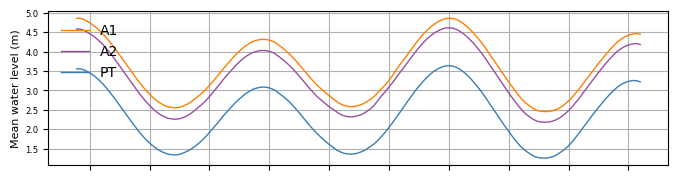

In [152]:
colours = ['#377eb8','#ff7f00','#984ea3']
############ A1        A2       P1


fig, (ax1) = plt.subplots(figsize=(8,2), dpi=100)

ax1.plot(A1_z.time, A1_z['water_level'], lw=1, c=colours[1], label='A1')
ax1.plot(A2_z.time, A2_z['water_level'], lw=1, c=colours[2], label='A2')
ax1.plot(PT_z.time, PT_z['water_level'], lw=1, c=colours[0], label='PT')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_ylabel('Mean water level (m)', fontsize=8)
ax1.set_xticklabels('')
ax1.legend(loc=2,frameon=False)
ax1.grid()



In [155]:
print('Zero-crossing Hz mean:')
print(
    A1_z.Hz.mean(),
    A2_z.Hz.mean(),
    PT_z.Hz.mean())

print('Zero-crossing Hs mean:')
print(
    A1_z.Hs.max(),
    A2_z.Hs.max(),
    PT_z.Hs.max())


print('Spectral Hm0 mean:')
print(
    A1_s.Hm0.mean(),
    A2_s.Hm0.mean(),
    PT_s.Hm0.mean())

print('Spectral Tm01 mean:')
print(
    A1_s.Tm01.mean(),
    A2_s.Tm01.mean(),
    PT_s.Tm01.mean())

print('Zero-crossing Ts mean:')
print(
    A1_z.Ts.mean(),
    A2_z.Ts.mean(),
    PT_z.Ts.mean())



Zero-crossing Hz mean:
0.14209510189701013 0.1329261540297275 0.13020421183651798
Zero-crossing Hs mean:
0.3068299856415549 0.2698515484718612 0.2959398313185551
Spectral Hm0 mean:
0.2576033867988607 0.22394017752682316 0.37392074046710383
Spectral Tm01 mean:
6.812119081159417 6.761050176819123 9.301011449171195
Zero-crossing Ts mean:
7.423190984529294 7.559524925335911 7.488080960977094


# CALCULATE WAVE PARAMETERS 




# Wave power

In [163]:
#########################################################################################################
#####################         Wave power calculation     ################################################

#########################################################################################################
######### Wave length is calculated from the Newton-Raphson method following: ###########################
####### Copied from: https://au.mathworks.com/matlabcentral/fileexchange/10557-wavelength ###############
"""
INPUT VARIABLES:
T = Wave Period, (seconds)
d = Water Depth, (m)
U = Current Velocity, (m/s)
delta = direction of current (rad) with
respect to the cross-shore direction
alpha = direction of waves (rad) with
respect to the cross-shore direction
tol = Maximum tolerance allowed for L
the default is 1e-6 (Generally 3 iterations)

OUTPUT VARIABLES:
L = Wave length, (m)
e = Relative error of L
c = Iteratios
"""

def wavelength(data, tol=1e-6):
    """Solves the dispersion relation for ocean surface waves."""
    # gravity
    g = 9.81
    
    # Default values if no inputs provided
    T = data['Tz']
    d = data['water_level']
    delta = 0
    alpha = 0
    U = 0

    # Initialize tolerance, error, and counter
    if tol is None:
        tol = 1e-6
    Lo = g * T**2 / (2 * np.pi)  # deep water wave length
    L = Lo * np.sqrt(np.tanh(4 * np.pi**2 * d / T**2 / g))
    e = L  # Initialize error
    c = 0  # Counter
    
    # Newton-Raphson method
    while any(e > tol):
        c += 1
        k = 2 * np.pi / L
        if isinstance(T, (int, float)):
            a = Lo * np.tanh(k * d) - L
            b = -2 * Lo * (1 - np.tanh(k * d)**2) * np.pi / L**2 * d - 1
        else:
            a = Lo * np.tanh(k * d) / np.sqrt(1 - U * np.cos(delta - alpha) * T / L) - L
            b = -1/2 * (-4 * Lo * np.pi * d * L + 4 * Lo * np.pi * d * U * np.cos(delta - alpha) * T
                        - Lo * np.sinh(k * d) * U * np.cos(delta - alpha) * T * L * np.cosh(k * d)
                        - 2 * L**3 * (-(-L + U * np.cos(delta - alpha) * T) / L)**(1/2) * np.cosh(k * d)**2
                        + 2 * L**2 * (-(-L + U * np.cos(delta - alpha) * T) / L)**(1/2) * np.cosh(k * d)**2
                        * U * np.cos(delta - alpha) * T) / (-L + U * np.cos(delta - alpha) * T) / L**2 \
                        / (-(-L + U * np.cos(delta - alpha) * T) / L)**(1/2) / np.cosh(k * d)**2
        L2 = L - a / b
        e = np.abs(L2 - L)
        L = L2
        
    print('Calculated wavelength L')
    print(f"Iterations = {c}")
    print(f"Relative error of L: {e}")
    
    data['L_int'] = L
    
    return


In [165]:
def calc_wave_power_intermediate(data):
    # Constants
    rho = 1025  # sea-water density in kg/m^3
    g = 9.81   # gravitational acceleration in m/s^2

    # Extract data from the dataframe
    Hs = data['Hs'].values  # significant wave height in meters
    Tz = data['Tz'].values  # zero-upcrossing wave period in seconds
    h = data['water_level'].values
    wavelength(data)
    L = data['L_int'].values

    # Calculate wave number (k) and wave celerity (c) using the dispersion relation
    k = (2 * np.pi) / L
    w = (2 * np.pi) / Tz

    c = np.sqrt(g /k * np.tanh(k * h))
    Cg = (c/2) * (1+k*h * (1-(np.tanh(k * h)**2))/(np.tanh(k*h)))

    # Calculate wave energy density (E)
    E = 1/8 * rho * g * Hs**2
    data['E_int'] = E
    # Calculate wave power (P) for current data point
    P = Cg * E

    # Add the calculated wave power to the dataframe
    data['P_int'] = P

    return

In [167]:
calc_wave_power_intermediate(PT_z)
calc_wave_power_intermediate(A1_z)
calc_wave_power_intermediate(A2_z)

Calculated wavelength L
Iterations = 4
Relative error of L: 0      2.131628e-14
1      1.776357e-14
2      1.421085e-14
3      1.776357e-14
4      2.131628e-14
           ...     
146    3.197442e-14
147    2.842171e-14
148    3.552714e-14
149    3.552714e-14
150    3.552714e-14
Length: 151, dtype: float64
Calculated wavelength L
Iterations = 4
Relative error of L: 0      1.421085e-14
1      1.421085e-14
2      3.552714e-15
3      7.105427e-15
4      3.552714e-15
           ...     
144    1.421085e-14
145    3.552714e-15
146    4.263256e-14
147    7.105427e-15
148    0.000000e+00
Length: 149, dtype: float64
Calculated wavelength L
Iterations = 4
Relative error of L: 0      1.421085e-14
1      1.421085e-14
2      3.552714e-15
3      1.421085e-14
4      1.421085e-14
           ...     
144    2.842171e-14
145    2.842171e-14
146    4.263256e-14
147    2.842171e-14
148    4.263256e-14
Length: 149, dtype: float64


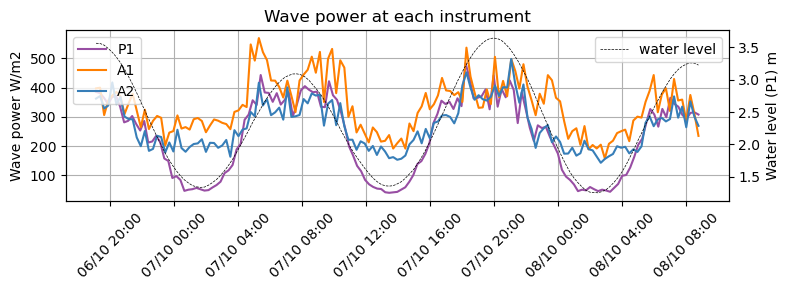

In [172]:
fig, ax = plt.subplots(figsize = (8,3))
ax2 = ax.twinx()
variable = 'P_int'
ax.plot(PT_z.time, PT_z[variable], c=colours[2], label = 'P1')
ax.plot(A1_z.time, A1_z[variable], c=colours[1],  label = 'A1')
ax.plot(A2_z.time, A2_z[variable], c=colours[0],  label = 'A2')
ax2.plot(PT_z.time, PT_z['water_level'], c='k', ls = '--', label = 'water level', lw = 0.5)
plt.title('Wave power at each instrument')
ax.grid()
ax.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
ax.set_ylabel('Wave power W/m2')
ax2.set_ylabel('Water level (P1) m')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))
# Setting x-axis labels rotation
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.tight_layout()

## Check for wave breaking

In [74]:
#
def wave_breaking(data):
    data['gamma'] = data['Hs'] * 2 / data['water_level']
    # From duce - use Hmax (2*Hs) for wave breaking
    data['breaking'] = False
    for data in data['gamma']:
        if data>0.6:
            data['breaking'] == 'True'
    return
wave_breaking(PT_z)
wave_breaking(A1_z)
wave_breaking(A2_z)


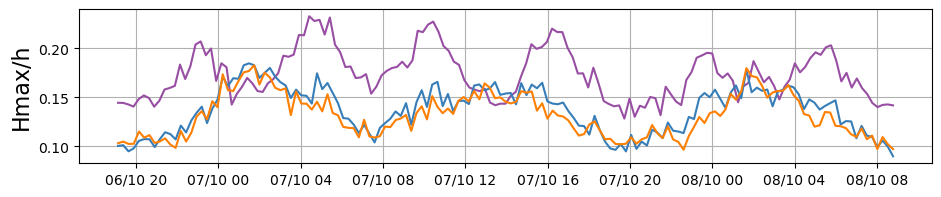

In [76]:
fig, ax = plt.subplots(figsize = (11,2))
ax.plot(PT_z['time'], PT_z['gamma'], c = colours[2])
ax.plot(A1_z['time'], A1_z['gamma'], c = colours[0])
ax.plot(A2_z['time'], A2_z['gamma'], c = colours[1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H'))
ax.set_ylabel('Hmax/h', size = 16)

plt.grid()
plt.savefig(r'C:\Users\lachl\OneDrive - The University of Sydney (Staff)\Desktop\OTI - October 2022\2023_Analysis_waves_adv_pt\outputs\breaking_gamma.png', transparent = True)

In [80]:
def steepness(data):
    data['steepness']  = data['Hs'] / data['L_int']
steepness(A1_z)
steepness(A2_z)
steepness(PT_z)

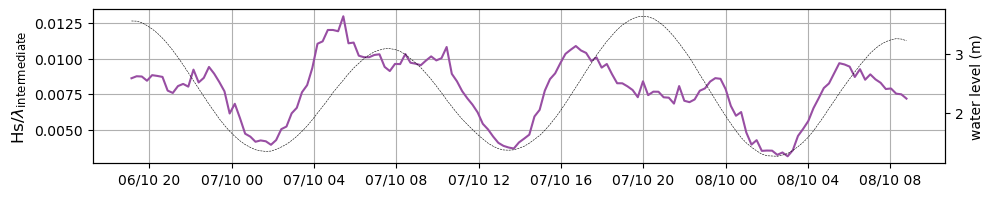

In [82]:
fig, ax = plt.subplots(figsize = (11,2))
ax2 = ax.twinx()
ax2.plot(PT_z['time'], PT_z['water_level'], c = 'k', ls = '--', lw = 0.4, label = 'water level')
ax2.set_ylabel('water level (m)')
ax.plot(PT_z['time'], PT_z['steepness'], label = 'Steepness', c = colours[2])
ax.set_ylabel(r'Hs/$\lambda_{\text{intermediate}}$', size = 12)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H'))
